# Compare reservoir models
***

**Author:** *Chus Casado Rodríguez*<br>
**Date:** *23-04-2025*<br>

**Introduction:**<br>

This notebooks compares the results of simulating 97 reservoirs from the ResOpsUS. These reservoirs were selected because the include observed data for the three variables inflow, storage and outflow for at least 8 consecutive years.

**Ideas:**<br>

In [1]:
# import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from pathlib import Path
# import geopandas as gpd
import yaml
import pickle

from lisfloodreservoirs import Config, read_attributes, read_timeseries
from lisfloodreservoirs.utils.plots import maps_performance, boxplot_parameters, boxplot_comparison
from lisfloodreservoirs.utils.metrics import KGEmod, ECDF, PDE
from lisfloodreservoirs.utils.utils import CDF, get_normal_value, return_period
from lisfloodreservoirs.calibration import read_results

In [2]:
plt.rcParams.update({
    "font.family": 'Arial',
    "font.size": 13,       # Default font size for text
    "axes.titlesize": 16,  # Title font size
    "axes.labelsize": 12,  # X and Y label font size
    "xtick.labelsize": 13, # X tick font size
    "ytick.labelsize": 12, # Y tick font size
    "legend.fontsize": 12  # Legend font size
})

## Configuration

In [3]:
cfg = Config('Z:/nahaUsers/casadje/datasets/reservoirs/ResOpsUS/v2.0/results/mhm/config_storage.yml')

PATH_RESULTS = cfg.PATH_DEF.parent.parent
print(f'Results will be saved in {PATH_RESULTS}')

models = ['linear', 'lisflood', 'hanazaki_5pars', 'mhm', 'starfit']

runs = {
    'default': 'default',
    'SCEUA-Q': 'calibration/univariate/outflow',
    'SCEUA-S': 'calibration/univariate/storage',
    'SCEUA-QS': 'calibration/bivariate'
}

Results will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsUS\v2.0\results


## Data

### Attributes

In [4]:
# list of reservoirs to be trained
reservoirs = pd.read_csv(cfg.RESERVOIRS_FILE, header=None).squeeze().tolist()

# import all tables of attributes
attributes = read_attributes(cfg.PATH_DATA / 'attributes', reservoirs)

# invert the one-hot encoder of main reservoir use
col_use = attributes.columns[attributes.columns.str.contains('MAIN_')]
col_use = [col for col in col_use if 'BASIN' not in col]
main_use = attributes[col_use].idxmax(axis=1)
attributes['MAIN_USE'] = main_use.replace({col: col.split('_')[-1] for col in col_use})
attributes.drop(col_use, axis=1, inplace=True)

print(f'{len(attributes)} reservoirs in the attributes table')

123 reservoirs in the attributes table


Create shapefile of the reservoirs selected for the model comparison.

```Python
import geopandas as gpd

# convert to GeoPandas
attributes = gpd.GeoDataFrame(
    attributes,
    geometry=gpd.points_from_xy(attributes.LON_LISFLOOD, attributes.LAT_LISFLOOD),
    crs='epsg:4326'
)

# export shapefile
attributes.to_file(cfg.PATH_DATA / 'selection' / 'reservoirs.shp')
```

#### Time series

In [5]:
# training periods
with open(cfg.PERIODS_FILE, 'rb') as file:
    periods = pickle.load(file)
# periods = {str(ID): {f'{x}_dates': [date] for x, date in dct.items()} for ID, dct in periods.items()}

# read time series
timeseries = read_timeseries(
    cfg.PATH_DATA / 'time_series' / 'csv',
    attributes.index,
    periods
)
print(f'{len(timeseries)} reservoirs in the time series')

# compute 100-year return period of the inflow
Q100 = [return_period(ts.inflow, T=100) for grand_id, ts in timeseries.items()]
Q100 = xr.DataArray(data=Q100, coords=[list(timeseries)], dims=['ID'])

  0%|          | 0/123 [00:00<?, ?it/s]

123 reservoirs in the time series


## Load results

In [6]:
parameters = {}
performance = []
for model in tqdm(models, desc='reservoir model'):

    pars_model = []
    perf_model = []
    for run, subpath in runs.items():

        path = PATH_RESULTS / model / subpath

        # load parameters
        try:
            pars_run = []
            for file in path.glob('*_parameters.yml'):
                grand_id = int(file.stem.split('_')[0])
                if grand_id not in reservoirs:
                    continue
                with open(file, 'r') as f:
                     dct = yaml.load(f, Loader=yaml.FullLoader)
                ds = xr.Dataset({key: xr.DataArray(value) for key, value in dct.items()})
                ds = ds.assign_coords(ID=[grand_id], run=[run])
                pars_run.append(ds)
            pars_model.append(xr.concat(pars_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading parameters from model {model} and run {run}:\n{e}')                                
        
        # load performance
        try:
            perf_run = []
            for file in (path).glob('*_performance.csv'):
                grand_id = int(file.stem.split('_')[0])
                if grand_id not in reservoirs:
                    continue
                ds = xr.Dataset.from_dataframe(pd.read_csv(file, index_col='metric'))
                ds = ds.assign_coords(model=[model], run=[run], ID=[grand_id])
                perf_run.append(ds)
            perf_model.append(xr.concat(perf_run, dim='ID'))
        except Exception as e:
            print(f'Error while reading performance from model {model} and run {run}:\n{e}')  
    
    try:
        parameters[model] = xr.concat(pars_model, dim='run')
    except:
        pass
    try:
        performance.append(xr.concat(perf_model, dim='run'))
    except:
        pass

performance = xr.concat(performance, dim='model')

# rename model 'hanazaki' as 'camaflood'
# performance = performance.assign_coords(
#     model=[m if 'hanazaki' not in m else m.replace('hanazaki', 'camaflood') for m in performance.model.values]
# )
performance = performance.assign_coords(
    model=[m if 'hanazaki' not in m else 'camaflood' for m in performance.model.values]
)

reservoir model:   0%|          | 0/5 [00:00<?, ?it/s]

Error while reading parameters from model starfit and run default:
must supply at least one object to concatenate
Error while reading performance from model starfit and run default:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-Q:
must supply at least one object to concatenate
Error while reading performance from model starfit and run SCEUA-Q:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-S:
must supply at least one object to concatenate
Error while reading performance from model starfit and run SCEUA-S:
must supply at least one object to concatenate
Error while reading parameters from model starfit and run SCEUA-QS:
must supply at least one object to concatenate


## Analysis

### Performance

#### Compare simulations

In [13]:
from typing import Optional, Union
from matplotlib.patches import Patch

def boxplot_comparison(
    performance: xr.Dataset,
    ax_dim: str,
    col_dim: str,
    metric: str = 'KGE',
    save: Optional[Union[str, Path]] = None,
    **kwargs,
):
    """
    Generate side-by-side boxplots comparing model performance across different metrics, storage/outflow components,
    and categories (e.g., model types or parameter sets).

    Parameters
    ----------
    performance : xr.Dataset
        An xarray dataset containing performance scores. It must include the specified `ax_dim`, `col_dim`, 
        and a 'metric' dimension, with variables named 'storage' and 'outflow'.
    ax_dim : str
        Dimension of the dataset to map to different subplots (columns of subplots). Typically a grouping like 
        region or threshold.
    col_dim : str
        Dimension that identifies the groups within each boxplot (e.g., different models, scenarios, etc.).
    metric : str, optional
        Performance metric to be plotted (default is 'KGE'). This selects a slice from the 'metric' dimension.
    save : str or Path, optional
        Path to save the figure. If None, the plot is not saved.

    **kwargs : dict, optional
        Additional plot customization options:
        - width (float): Width of each boxplot group (default: 0.15)
        - figsize (tuple): Size of the figure in inches (default: (6, 3))
        - alpha (float): Transparency of the boxplot fill (default: 0.7)

    Notes
    -----
    The function also computes a composite performance index called 'storage & outflow', calculated as:
        1 - sqrt[(1 - storage)^2 + (1 - outflow)^2]
    This is included alongside the individual 'storage' and 'outflow' scores.

    A color-coded legend is added automatically based on the values in `col_dim`.

    Returns
    -------
    None
        Displays the plot and optionally saves it to a file.
    """

    w = kwargs.get('width', .15)
    figsize = kwargs.get('figsize', (6, 3))
    alpha = kwargs.get('alpha', .7)
    
    colors = ['grey', 'salmon', 'gold', 'steelblue', 'olivedrab']
    colors = {str(key): color for key, color in zip(performance[col_dim].data, colors)}
    
    n = len(performance[ax_dim])
    fig, axes = plt.subplots(ncols=n, figsize=(figsize[0] * n, figsize[1]))#, sharey=True)

    for ax, title in zip(axes, performance[ax_dim].data):
    
        perf = performance.sel({ax_dim: title, 'metric': metric})
        perf = perf.dropna(col_dim, how='all')
        
        perf_dct = {var: perf[var].to_pandas().transpose() for var in ['outflow', 'storage']}
        perf_dct['outflow &\nstorage'] = 1 - ((1 - perf_dct['outflow'])**2 + (1 - perf_dct['storage'])**2)**.5
    
        ticks_labels = {x: var for x, var in enumerate(perf_dct, start=1)}
        for x, var in ticks_labels.items():
            df = perf_dct[var]
            pos = x - (df.shape[1] / 2 - .5) * w
            for i, (col, c) in enumerate(colors.items()):
                if col not in df.columns:
                    continue
                ax.boxplot(
                    df[col],
                    positions=[pos + i * w],
                    widths=[w * .9],
                    patch_artist=True,
                    showfliers=False,
                    capprops=dict(linewidth=0),
                    boxprops=dict(facecolor=c, edgecolor='none', alpha=alpha),
                    whiskerprops=dict(color=c),
                    medianprops=dict(color='k')
                )
        ax.tick_params(axis='x', length=0)
        ax.set(
            ylim=(-1, 1),
            ylabel=metric,
            title=title
        )
        ax.spines[['top', 'right', 'bottom']].set_visible(False)
        ax.set_xticks(list(ticks_labels.keys()))
        ax.set_xticklabels(list(ticks_labels.values()))
        ax.set_yticks([-1, -.5, 0, .5, 1])
        
    # Add legend
    legend_handles = [Patch(facecolor=c, edgecolor='none', alpha=.7, label=col) for col, c in colors.items()]
    fig.legend(handles=legend_handles, frameon=False, loc=6, bbox_to_anchor=[.90, 0, .05, 1]);

    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight');

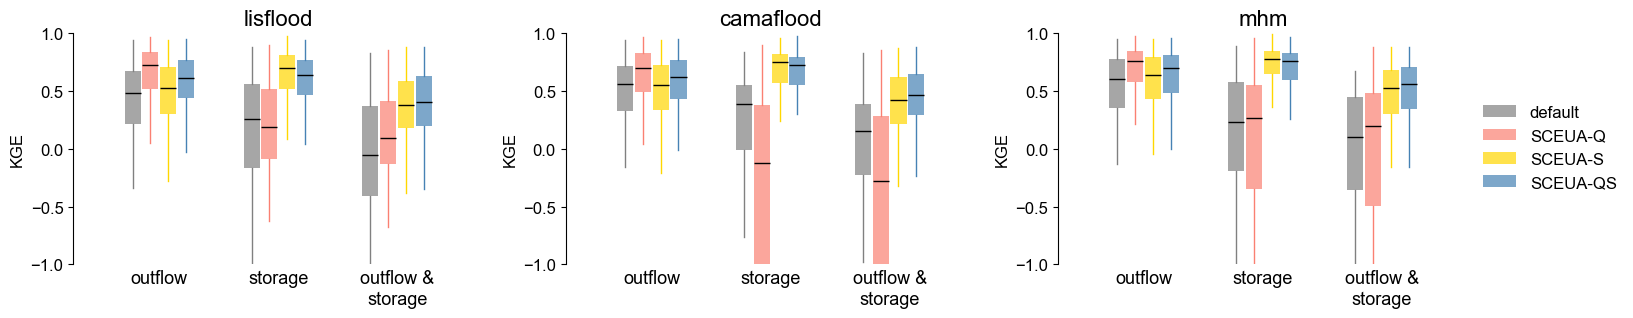

In [17]:
# compare runs
boxplot_comparison(
    performance.sel(model=['lisflood', 'camaflood', 'mhm'], run=['default', 'SCEUA-Q', 'SCEUA-S', 'SCEUA-QS']),
    ax_dim='model',
    col_dim='run',
    save=PATH_RESULTS / f'boxplots_compare_variables.jpg'
)

#### Compare models

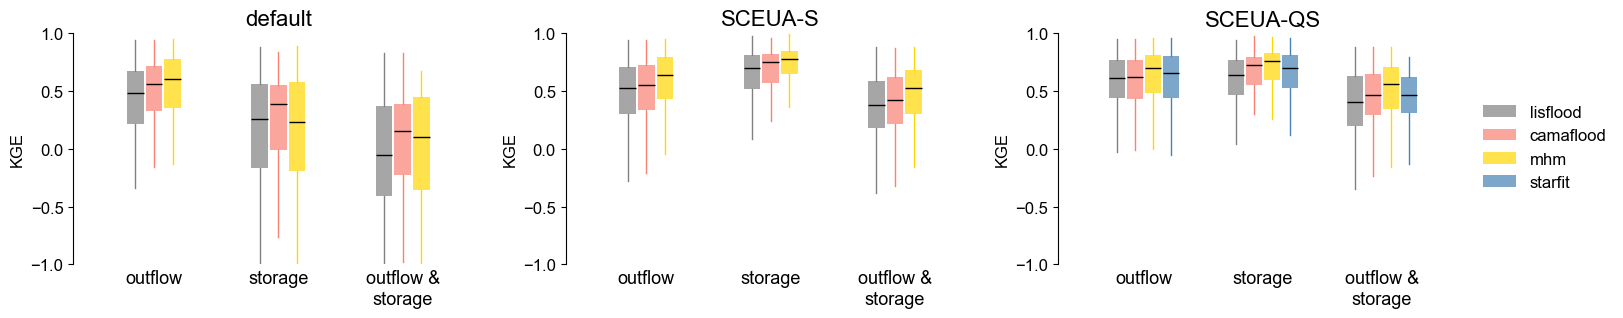

In [18]:
# compare models
boxplot_comparison(
    performance.sel(model=['lisflood', 'camaflood', 'mhm', 'starfit'], run=['default', 'SCEUA-S', 'SCEUA-QS']),
    ax_dim='run',
    col_dim='model',
    save=PATH_RESULTS / f'boxplots_compare_models.jpg'
)

***

Figure explaining the mHM model.

```Python
from mpl_toolkits.mplot3d import Axes3D

demand_vals = np.linspace(0, 20, 50)
inflow_vals = np.linspace(0, 20, 50)
D, I = np.meshgrid(demand_vals, inflow_vals)
omega = 0.1
dor = 1.176
beta = 1
gamma = 0.85
lamb = 1

rho = min(1, (1 / dor)**beta)
print(f'rho = {rho:.3f}')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for V in [0.01, .25, 0.5, .75, 0.99]:
    kappa = (V / gamma)**lamb
    Q = rho * kappa * D + (1 - rho) * I
    color = plt.cm.magma(V)
    ax.plot_surface(D, I, Q, color=color)#cmap=cmap, alpha=.75)
# ax.set_xlabel('demand')
# ax.set_ylabel('inflow')
# ax.set_zlabel('outflow')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title('Outflow as a Function of Demand, Inflow & Storage')
plt.show()
```

***

***

### Parameters

#### Linear

In [ ]:
model = 'linear'
parameter_range = {'T': [7, 2190]}

pars_model = parameters[model][list(parameter_range)]

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# pairplot comparing runs for each parameter
for parname, da in pars_model.items():
    data = da.to_pandas().transpose()
    pairplot= sns.pairplot(data=data,
                           # diag_kind='hist',
                           # hue='MAIN_USE', 
                           corner=True);
    pmin, pmax = parameter_range[parname]
    pmin -= 2e-2
    pmax += 2e-2
    for ax in pairplot.axes.flatten():
        if ax is None:
            continue
        ax.set(xlim=(pmin, pmax),
               ylim=(pmin, pmax))
    pairplot.fig.suptitle(parname, y=.95);
    plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Lisflood

In [ ]:
model = 'lisflood'

parameter_range = {
    'alpha': [0.20, 0.99],
    'beta': [0.001, 0.999],
    'gamma': [0.001, 0.999],
    'delta': [0.1, 0.5],
    'epsilon': [0.001, 0.999],
    'k': [1.0, 5.0]
}

pars_model = parameters[model]
pars_model = xr.Dataset({
    'alpha': pars_model['Vf'] / pars_model['Vtot'],
    'beta': (pars_model['Vn'] - pars_model['Vmin']) / (pars_model['Vf'] - pars_model['Vmin']),
    'gamma': (pars_model['Vn_adj'] - pars_model['Vn']) / (pars_model['Vf'] - pars_model['Vn']),
    'delta': pars_model['Qf'] / Q100,
    'epsilon': pars_model['Qn'] / pars_model['Qf'],
    'k': pars_model['k']
})

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        palette='Spectral',
        diag_kind='hist',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.8, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

In [ ]:
pars_model.median('ID').to_pandas()

#### Hanazaki

In [ ]:
ds = parameters['hanazaki']

ds

In [ ]:
ds.where((ds['Ve'] > ds['Vtot']).any('run'), drop=True)

In [ ]:
ds[['Qmin', 'Qn']].sel(ID=[7313]).to_dataframe()

In [ ]:
from lisfloodreservoirs.models import Lisflood

In [ ]:
res = Lisflood(Qf=347,
               Qmin=0.0,
               Qn=6.4,
               Vf=105879765,
               Vmin=11089100,
               Vn=83263414,
               Vn_adj=97339496,
               Vtot=110891000,
               k=1.158)

In [ ]:
res.plot_routine()

In [ ]:
ts = timeseries[42]
sim = res.simulate(ts.inflow, ts.storage.iloc[0], routine=1, limit_Q=True)

In [ ]:
res.get_params()

In [ ]:
res.scatter(sim, ts, norm=False,
            Vlims=[11089100, 83263414, 97339496, 105879765],
            Qlims=[0.0, 6.4, 6.4, 347])

In [ ]:
ts.inflow.mean() * 3600 * 24 * 1e-6

In [ ]:
(res.Vf - res.Vn_adj) * 1e-6

In [ ]:
ds[['Vtot', 'Vf']].sel(ID=1777).to_pandas()

In [ ]:
pars_model['alpha'].where(pars_model['alpha'] < 0.2, drop=True).to_pandas()

In [ ]:
pars_model['epsilon'].to_pandas().min(axis=1)

In [ ]:
timeseries[1777].storage.plot()

In [ ]:
attributes.loc[1777, 'CAP_MCM']

In [ ]:
model = 'hanazaki'

parameter_range = {
    'alpha': [0.2, 0.99],
    'beta': [0.001, 0.999],    
    'gamma': [0.001, 0.999],
    'delta': [0.1, 0.5],
    'epsilon': [0.001, 0.999]
}

pars_model = parameters[model]
pars_model = xr.Dataset({
    'alpha': pars_model['Vf'] / pars_model['Vtot'],
    'beta': (pars_model['Vtot'] - pars_model['Ve']) / (pars_model['Vtot'] - pars_model['Vf']),
    'gamma': pars_model['Vmin'] / pars_model['Vf'],
    'delta': pars_model['Qf'] / Q100,
    'epsilon': pars_model['Qn'] / pars_model['Qf']
})

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

#### mHM

In [ ]:
model = 'mhm'

parameter_range = {
    'w': [0.0, 1.0],
    'alpha': [0.0, 5.0],
    'beta': [0.5, 3.0],
    'gamma': [0.0, 1.0],
    'lambda': [0.25, 3.0]
}

pars_model = parameters[model][list(parameter_range)]

# boxplot comparing parameterizations across calibration runs
boxplot_parameters(pars_model, parameter_range, save=PATH_RESULTS / model / 'parameters_boxplot.jpg')

# pairplot comparing parameters
if len(pars_model) > 1:
    pairplot = sns.pairplot(
        data=pars_model.to_dataframe().reset_index(),
        vars=list(parameter_range),
        hue='run',
        # palette='magma',
        corner=True,
        dropna=True,
        plot_kws={'alpha': 0.666, 's': 10},
    );
    plt.savefig(PATH_RESULTS / model / 'parameters_pairplot.jpg', dpi=300, bbox_inches='tight')

# # pairplot comparing runs for each parameter
# for parname, da in pars_model.items():
#     data = da.to_pandas().transpose()
#     pairplot= sns.pairplot(data=data,
#                            # diag_kind='hist',
#                            # hue='MAIN_USE', 
#                            corner=True);
#     pmin, pmax = parameter_range[parname]
#     pmin -= 2e-2
#     pmax += 2e-2
#     for ax in pairplot.axes.flatten():
#         if ax is None:
#             continue
#         ax.set(xlim=(pmin, pmax),
#                ylim=(pmin, pmax))
#     pairplot.fig.suptitle(parname, y=.95);
#     plt.savefig(PATH_RESULTS / model / f'parameter_{parname}_pairplot.jpg', dpi=300, bbox_inches='tight')

In [ ]:
pars_model.median('ID').to_pandas()

## Correct parameter files

```Python
from lisfloodreservoirs.calibration import read_results
from lisfloodreservoirs.utils.timeseries import create_demand
from lisfloodreservoirs.models import get_model
import copy

for model in ['mhm']:
    for run in ['SCEUA-Q', 'SCEUA-S', 'SCEUA-QS']:
        # path results
        path = PATH_RESULTS / model / runs[run]

        for file in path.glob('*samples.csv'):
                    
            # reservoir ID and time series
            grand_id = int(file.stem.split('_')[0])
            ts = timeseries[grand_id]

            # storage attributes (m3)
            Vtot = ts.storage.max()
            Vmin = max(0, ts.storage.min())
            # flow attributes (m3/s)
            Qmin = max(0, ts.outflow.min())
            # model-independent reservoir attributes
            reservoir_attrs = {
                'Vmin': Vmin,
                'Vtot': Vtot,
                'Qmin': Qmin,
                }
            if model == 'hanazaki':
                # catchment area (m2)
                A = int(attributes.loc[grand_id, 'CATCH_SKM'] * 1e6)
                reservoir_attrs.update({'A': A})
                del reservoir_attrs['Qmin']
            elif model == 'mhm':
                # create a demand time series
                bias = ts.outflow.mean() / ts.inflow.mean()
                demand = create_demand(ts.outflow,
                                       water_stress=min(1, bias),
                                       window=28)

            # read calibration results
            iterations, attributes = read_results(file)

            # udpate reservoir attributes
            calibrated_attrs = copy.deepcopy(reservoir_attrs)
            if model == 'hanazaki':
                Vf = float(ts.storage.quantile(attributes['alpha']))
                Ve = Vtot - attributes['beta'] * (Vtot - Vf)
                Vmin = attributes['gamma'] * Vf
                Qn = attributes['delta'] * ts.inflow.mean()
                Qf = attributes['epsilon'] * return_period(ts.inflow, T=100)
                calibrated_attrs.update({
                    'Vf': Vf,
                    'Ve': Ve,
                    'Vmin': Vmin,
                    'Qn': Qn,
                    'Qf': Qf,
                    'A': A
                })
            elif model == 'mhm':
                calibrated_attrs.update(attributes)
                calibrated_attrs.update({
                    'avg_inflow': ts.inflow.mean(),
                    'avg_demand': demand.mean()
                })

            # declare reservoir
            res = get_model(model, **calibrated_attrs)
            
            # export calibrated attributes
            with open(path / f'{grand_id}_optimal_attributes.yml', 'w') as f:
                yaml.dump(res.get_params(), f)
```